# ASTRO 533 - Final Project

**Created:** Dec. 2020   
**Last Edit:** Dec. 2020  

**Author:** Bill Chen  
**Email:** ybchen@umich.edu  

## Load packages and read data

In [1]:
import numpy as np
from illustris_api import get
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.table import Table as tb
import astropy.coordinates as coord
import astropy.units as u
from astropy.units import cds
import copy
plt.style.use('bill')

my_YlGnBu = copy.copy(mpl.cm.get_cmap('YlGnBu')) # copy the default cmap
my_YlGnBu.set_bad('w')

my_magma = copy.copy(mpl.cm.get_cmap('magma'))
my_magma.set_bad(my_magma(-1))

nyu_cat = tb.read('../Project_mid2/lowz_catalog.dr4.fits', format='fits')

In [2]:
print(nyu_cat.keys())

['OBJECT_POSITION', 'ICOMB', 'SECTOR', 'VAGC_SELECT', 'FGOTMAIN', 'MMAX', 'RA', 'DEC', 'RUN', 'RERUN', 'CAMCOL', 'FIELD', 'ID', 'OBJC_ROWC', 'OBJC_COLC', 'PLATE', 'FIBERID', 'MJD', 'PLUG_RA', 'PLUG_DEC', 'QUALITY', 'ABSMAG', 'ABSMAG_IVAR', 'MU50R', 'PSF_FWHM', 'KCORRECT', 'PETROFLUX', 'PETROFLUX_IVAR', 'MODELFLUX', 'MODELFLUX_IVAR', 'EXTINCTION', 'PETROTHETA', 'PETROTH50', 'PETROTH90', 'SERSIC_N', 'SERSIC_TH50', 'SERSIC_FLUX', 'VDISP', 'VDISP_ERR', 'CLASS', 'SUBCLASS', 'VMAX', 'NEDNAME', 'NEDCZ', 'ZHELIO', 'ZLG', 'ZDIST', 'ZDIST_ERR']


In [198]:
Mg = nyu_cat['ABSMAG'][:,1] - 5*np.log10(1) # Mg - 5logh
Mr = nyu_cat['ABSMAG'][:,2] - 5*np.log10(1) # Mr - 5logh
sigma = nyu_cat['VDISP']

ind_valid = np.where( (Mg>-30) & (Mr<-10) & (Mr>-30) & (Mg<-10) )[0]
Mg = Mg[ind_valid]
Mr = Mr[ind_valid]
sigma = sigma[ind_valid]

gr = Mg - Mr
idx_blue = np.where(gr<0.6)[0]
idx_red = np.where(gr>0.6)[0]

idx_low_sigma = np.where(sigma<70)[0]
idx_high_sigma = np.where(sigma>70)[0]

print(len(ind_valid))

49967


In [167]:
def V_eff(absmag):
    d = 10**(0.2 * (17.7 - absmag) -5) # in Mpc/h
    d_eff = np.clip(d, 10, 150)
    return (d_eff**3 - 10**3) / (150**3 - 10**3)

def kde_gauss(data, x, h, weights):
    k = sum(np.exp(-((x-data[:,None])/h)**2/2.)*weights[:,None])
    return k/(np.sqrt(2.*np.pi)*h)

def schechter(absmag, alpha, Mstar, bias=1):
    y = np.exp(-10**(-0.4*(absmag-Mstar))) * 10**(-0.4*(absmag-Mstar)*(alpha+1))
    return y * bias / ( np.sum(y) * (23-13)/len(absmag) )

def schechter_doub(absmag, alpha1, alpha2, Mstar, bias=1):
    y = np.exp(-10**(-0.4*(absmag-Mstar))) * ( 0.0156*10**(-0.4*(absmag-Mstar)*(alpha1+1)) +\
                                              0.0062*10**(-0.4*(absmag-Mstar)*(alpha2+1)) )
    return y * bias

In [199]:
absmag_bins = np.linspace(-23, -13, 50+1)

f_M, absmag_bins = np.histogram(Mr, bins=absmag_bins)
f_M = f_M / V_eff( (absmag_bins[1:]+absmag_bins[:-1])/2 )
f_M = f_M / ( np.sum(f_M) * (23-13)/50 )

absmags = np.linspace(-23, -13, 100)
f_M_kde = kde_gauss(Mr, absmags, h=0.1, weights=1/V_eff(Mr))
# f_M_kde = f_M_kde / ( np.sum(f_M_kde) * (23-13)/100 )
f_M_kde = f_M_kde / 760900

f_M_kde_red = kde_gauss(Mr[idx_red], absmags, h=0.1, weights=1/V_eff(Mr[idx_red]))
f_M_kde_blue = kde_gauss(Mr[idx_blue], absmags, h=0.1, weights=1/V_eff(Mr[idx_blue]))
f_M_kde_red = f_M_kde_red / 760900
f_M_kde_blue = f_M_kde_blue / 760900

f_M_kde_low_sigma = kde_gauss(Mr[idx_low_sigma], absmags, h=0.1, weights=1/V_eff(Mr[idx_low_sigma]))
f_M_kde_high_sigma = kde_gauss(Mr[idx_high_sigma], absmags, h=0.1, weights=1/V_eff(Mr[idx_high_sigma]))
f_M_kde_low_sigma = f_M_kde_low_sigma / 760900
f_M_kde_high_sigma = f_M_kde_high_sigma / 760900

In [35]:
log_bins = np.linspace(6, 16, 100+1)
bins = 10**log_bins
hmf = np.loadtxt('hsmf.txt') / (75**3) / (log_bins[1] - log_bins[0]) / np.log(10)
hmf_kde = np.loadtxt('hsmf_kde.txt') / (75**3) / np.log(10)
sub_hmf_kde = np.loadtxt('sub_hsmf_kde.txt') / (75**3) / np.log(10)

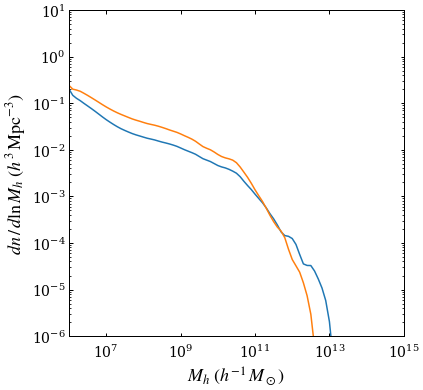

In [39]:
fig, ax = plt.subplots(figsize=(6,6))

# ax.step(bins[1:], hmf)
ax.plot(bins, hmf_kde)
ax.plot(bins, sub_hmf_kde)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{h}\ (h^{-1}\,M_\odot)$')
ax.set_ylabel(r'$dn\,/\,d\ln\,M_{h}\ (h^3\,{\rm Mpc}^{-3})$')
ax.set_xlim(1e6, 1e15)
ax.set_ylim(1e-6, 1e1)

# plt.savefig('./figures/hmf.pdf')
plt.show()

In [112]:
absmags = np.linspace(-23, -13, 100)
absmagbins = np.linspace(-23, -13, 100+1)

lf_kde = np.loadtxt('sub_hlf.txt') / (75**3)
lf_kde_tng300 = np.loadtxt('sub_hlf_tng300.txt') / (205**3)

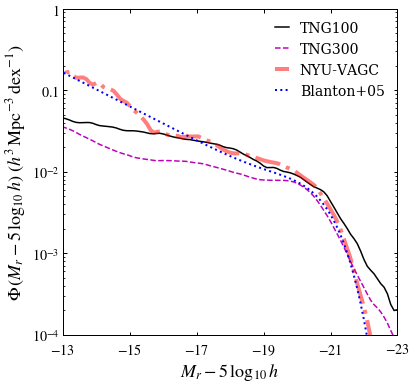

In [220]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(absmagbins, lf_kde, c='k', label=r'TNG100')
ax.plot(absmagbins, lf_kde_tng300, c='m', ls='--', label=r'TNG300')
ax.plot(absmags, f_M_kde*0.75, c='r', alpha=0.5, ls='-.', lw=4, label=r'NYU-VAGC')
ax.plot(absmags, schechter_doub(absmags, -0.17, -1.52, Mstar=-20.04, bias=0.4*np.log(10)), 
        c='b', ls=':', lw=2, label=r'Blanton+05')

ax.set_xlabel(r'$M_r-5\,\log_{10}\,h$')
ax.set_ylabel(r'$\Phi\,(M_r-5\,\log_{10}\,h)\ (h^3\,{\rm Mpc^{-3}\,dex^{-1}})$')
ax.set_yscale('log')
ax.set_xlim(-13, -23)
ax.set_ylim(1e-4, 1)
ax.set_xticks([-13, -15, -17, -19, -21, -23])
ax.set_xticklabels([r'$-13$', r'$-15$', r'$-17$', r'$-19$', r'$-21$', r'$-23$'])
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
ax.set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$0.1$', r'$1$'])
ax.legend()

plt.savefig('./figures/lf.pdf')
plt.show()

In [177]:
lf_kde_red = np.loadtxt('sub_hlf_red.txt') / (75**3)
lf_kde_blue = np.loadtxt('sub_hlf_blue.txt') / (75**3)

lf_kde_red_tng300 = np.loadtxt('sub_hlf_red_tng300.txt') / (205**3)
lf_kde_blue_tng300 = np.loadtxt('sub_hlf_blue_tng300.txt') / (205**3)

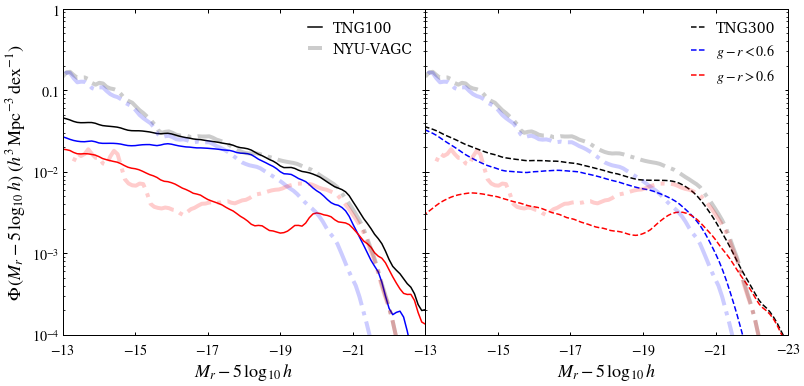

In [223]:
fig, [ax, ax1] = plt.subplots(1,2,figsize=(13,6), sharey=True)
fig.subplots_adjust(wspace=0)

ax.plot(absmagbins, lf_kde, c='k', label=r'TNG100')
ax.plot(absmagbins, lf_kde_blue, c='b')
ax.plot(absmagbins, lf_kde_red, c='r')
ax.plot(absmags, f_M_kde*0.75, c='k', alpha=0.2, ls='-.', lw=4, label=r'NYU-VAGC')
ax.plot(absmags, f_M_kde_blue*0.75, c='b', alpha=0.2, ls='-.', lw=4)
ax.plot(absmags[:-3], f_M_kde_red[:-3]*0.75, c='r', alpha=0.2, ls='-.', lw=4)

ax1.plot(absmagbins, lf_kde_tng300, c='k', ls='--', label=r'TNG300')
ax1.plot(absmagbins, lf_kde_blue_tng300, c='b', ls='--', label=r'$g-r<0.6$')
ax1.plot(absmagbins, lf_kde_red_tng300, c='r', ls='--', label=r'$g-r>0.6$')
ax1.plot(absmags, f_M_kde*0.75, c='k', alpha=0.2, ls='-.', lw=4)
ax1.plot(absmags, f_M_kde_blue*0.75, c='b', alpha=0.2, ls='-.', lw=4)
ax1.plot(absmags[:-3], f_M_kde_red[:-3]*0.75, c='r', alpha=0.2, ls='-.', lw=4)

ax.set_xlabel(r'$M_r-5\,\log_{10}\,h$')
ax1.set_xlabel(r'$M_r-5\,\log_{10}\,h$')
ax.set_ylabel(r'$\Phi\,(M_r-5\,\log_{10}\,h)\ (h^3\,{\rm Mpc^{-3}\,dex^{-1}})$')
ax.set_yscale('log')
ax.set_xlim(-13, -23)
ax1.set_xlim(-13, -23)
ax.set_ylim(1e-4, 1)
ax.set_xticks([-13, -15, -17, -19, -21])
ax.set_xticklabels([r'$-13$', r'$-15$', r'$-17$', r'$-19$', r'$-21$', r'$-23$'])
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
ax.set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$0.1$', r'$1$'])
ax1.set_xticks([-13, -15, -17, -19, -21, -23])
ax1.set_xticklabels([r'$-13$', r'$-15$', r'$-17$', r'$-19$', r'$-21$', r'$-23$'])
ax.legend()
ax1.legend()

plt.savefig('./figures/lf_color.pdf')
plt.show()

In [215]:
lf_kde_low_sigma = np.loadtxt('sub_hlf_low_sigma.txt') / (75**3)
lf_kde_high_sigma = np.loadtxt('sub_hlf_high_sigma.txt') / (75**3)

lf_kde_low_sigma_tng300 = np.loadtxt('sub_hlf_low_sigma_tng300.txt') / (205**3)
lf_kde_high_sigma_tng300 = np.loadtxt('sub_hlf_high_sigma_tng300.txt') / (205**3)

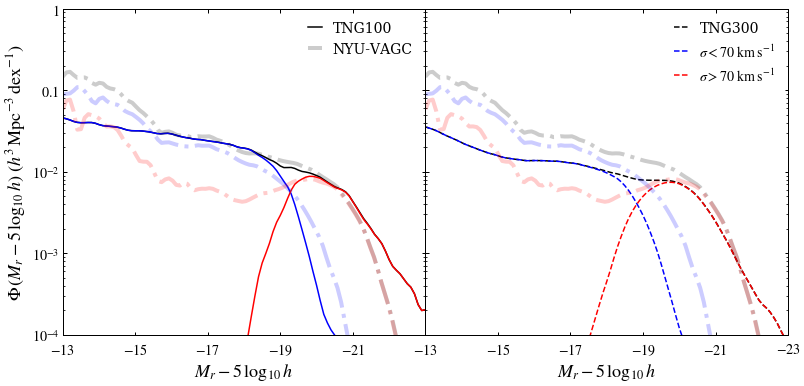

In [222]:
fig, [ax, ax1] = plt.subplots(1,2,figsize=(13,6), sharey=True)
fig.subplots_adjust(wspace=0)

ax.plot(absmagbins, lf_kde, c='k', label=r'TNG100')
ax.plot(absmagbins, lf_kde_low_sigma, c='b')
ax.plot(absmagbins, lf_kde_high_sigma, c='r')
ax.plot(absmags, f_M_kde*0.75, c='k', alpha=0.2, ls='-.', lw=4, label=r'NYU-VAGC')
ax.plot(absmags, f_M_kde_low_sigma*0.75, c='b', alpha=0.2, ls='-.', lw=4)
ax.plot(absmags, f_M_kde_high_sigma*0.75, c='r', alpha=0.2, ls='-.', lw=4)

ax1.plot(absmagbins, lf_kde_tng300, c='k', ls='--', label=r'TNG300')
ax1.plot(absmagbins, lf_kde_low_sigma_tng300, c='b', ls='--', label=r'$\sigma<70\ {\rm km\,s^{-1}}$')
ax1.plot(absmagbins, lf_kde_high_sigma_tng300, c='r', ls='--', label=r'$\sigma>70\ {\rm km\,s^{-1}}$')
ax1.plot(absmags, f_M_kde*0.75, c='k', alpha=0.2, ls='-.', lw=4)
ax1.plot(absmags, f_M_kde_low_sigma*0.75, c='b', alpha=0.2, ls='-.', lw=4)
ax1.plot(absmags, f_M_kde_high_sigma*0.75, c='r', alpha=0.2, ls='-.', lw=4)

ax.set_xlabel(r'$M_r-5\,\log_{10}\,h$')
ax1.set_xlabel(r'$M_r-5\,\log_{10}\,h$')
ax.set_ylabel(r'$\Phi\,(M_r-5\,\log_{10}\,h)\ (h^3\,{\rm Mpc^{-3}\,dex^{-1}})$')
ax.set_yscale('log')
ax.set_xlim(-13, -23)
ax1.set_xlim(-13, -23)
ax.set_ylim(1e-4, 1)
ax.set_xticks([-13, -15, -17, -19, -21])
ax.set_xticklabels([r'$-13$', r'$-15$', r'$-17$', r'$-19$', r'$-21$', r'$-23$'])
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
ax.set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$0.1$', r'$1$'])
ax1.set_xticks([-13, -15, -17, -19, -21, -23])
ax1.set_xticklabels([r'$-13$', r'$-15$', r'$-17$', r'$-19$', r'$-21$', r'$-23$'])
ax.legend()
ax1.legend()

plt.savefig('./figures/lf_sigma.pdf')
plt.show()